Prevendo a qualidade sensorial de um vinho (bom vs ruim) com base nas características físico-químicas e quais variáveis possuem maior influência na predição utilizando KNN + Undersampling e KNN + Oversampling

In [ ]:
%pip install --user scikit-learn imbalanced-learn pandas seaborn matplotlib pyarrow shap

In [61]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, precision_recall_curve, recall_score, f1_score, roc_curve, auc, classification_report, ConfusionMatrixDisplay
)
from imblearn.under_sampling import RandomUnderSampler
import shap
import matplotlib.pyplot as plt
import seaborn as sns

In [62]:
df = pd.read_parquet('data/processed/wine-quality.parquet')
print("Colunas do dataset carregado:", df.columns.tolist())

Colunas do dataset carregado: ['type', 'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']


In [63]:
# Target binária (quality > 5 = bom (1), <=5 ruim (0))
df['good_quality'] = (df['quality'] > 5).astype(int)
df.drop('quality', axis=1, inplace=True)

In [64]:
# Encoding da variável 'type'
if df['type'].dtype == 'object':
    le = LabelEncoder()
    df['type'] = le.fit_transform(df['type'])
    print("Coluna 'type' codificada.")
else:
    print("Coluna 'type' já está numérica.")

Coluna 'type' codificada.



Distribuição das classes (good_quality):
good_quality
1    4113
0    2384
Name: count, dtype: int64


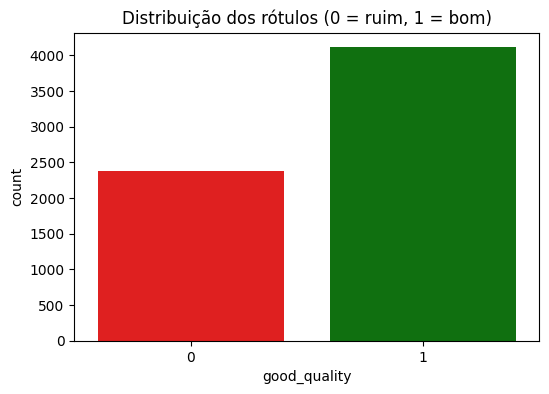

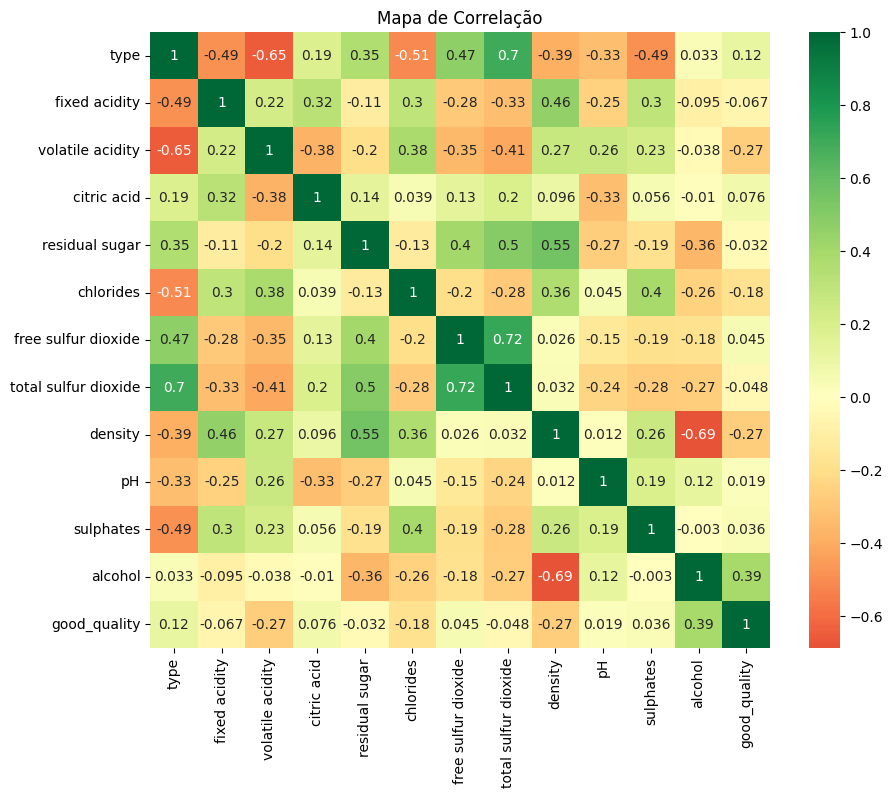

In [65]:
# Análise das classes
print("\nDistribuição das classes (good_quality):")
print(df['good_quality'].value_counts())

plt.figure(figsize=(6,4))
sns.countplot(x='good_quality', hue='good_quality', data=df, palette={0: 'red', 1: 'green'}, legend=False)
plt.title("Distribuição dos rótulos (0 = ruim, 1 = bom)")
plt.show()

plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn', center=0)
plt.title("Mapa de Correlação")
plt.show()

In [66]:
# X = variáveis independentes (características físico-químicas)
# y = variável dependente (qualidade do vinho)
X = df.drop('good_quality', axis=1)
y = df['good_quality']

In [67]:
# Dividindo treino e teste (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

Seção 1: KNN + Undersampling

In [68]:
# Balanceamento com undersampling (treino)
rus = RandomUnderSampler(random_state=42)
X_train_bal, y_train_bal = rus.fit_resample(X_train, y_train)

print(f'\nAntes do undersampling, treino tem {np.bincount(y_train)}')
print(f'Depois do undersampling, treino tem {np.bincount(y_train_bal)}')


Antes do undersampling, treino tem [1907 3290]
Depois do undersampling, treino tem [1907 1907]


In [69]:
# Normalização dos dados (fit no treino balanceado, aplicando em treino e teste)
scaler = StandardScaler()
X_train_bal_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled = scaler.transform(X_test)

In [70]:
# Ajuste de Hiperparâmetros com Cross-validation
param_grid = {
    'n_neighbors': list(range(5, 51, 5)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # Manhattan ou Euclidiana
}

grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid.fit(X_train_bal_scaled, y_train_bal)

print("\nMelhores parâmetros encontrados:", grid.best_params_)
best_knn = grid.best_estimator_


Melhores parâmetros encontrados: {'n_neighbors': 30, 'p': 1, 'weights': 'distance'}


In [71]:
# Avaliação de métricas
def gerar_tabela_metricas(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    report_train = classification_report(y_train, y_train_pred, output_dict=True)
    report_test = classification_report(y_test, y_test_pred, output_dict=True)

    linhas = ['Precisão', 'Recall', 'F1-Score', 'Suporte']
    index = pd.MultiIndex.from_product([['Teste', 'Treino'], linhas])

    tabela = pd.DataFrame(index=index, columns=['Vinhos Ruins', 'Vinhos Bons', 'Média', 'Média Ponderada'])

    def preencher(relatorio, tipo):
        tabela.loc[(tipo, 'Precisão')] = [
            relatorio['0']['precision'],
            relatorio['1']['precision'],
            relatorio['macro avg']['precision'],
            relatorio['weighted avg']['precision']
        ]
        tabela.loc[(tipo, 'Recall')] = [
            relatorio['0']['recall'],
            relatorio['1']['recall'],
            relatorio['macro avg']['recall'],
            relatorio['weighted avg']['recall']
        ]
        tabela.loc[(tipo, 'F1-Score')] = [
            relatorio['0']['f1-score'],
            relatorio['1']['f1-score'],
            relatorio['macro avg']['f1-score'],
            relatorio['weighted avg']['f1-score']
        ]
        tabela.loc[(tipo, 'Suporte')] = [
            relatorio['0']['support'],
            relatorio['1']['support'],
            np.nan,
            np.nan
        ]

    preencher(report_test, 'Teste')
    preencher(report_train, 'Treino')

    return tabela.round(3)


tabela_metricas = gerar_tabela_metricas(
    best_knn, X_train_bal_scaled, y_train_bal, X_test_scaled, y_test
)

print("\n===== Tabela de Métricas (Undersampled) =====")
print(tabela_metricas)

acc_train = accuracy_score(y_train_bal, best_knn.predict(X_train_bal_scaled))
acc_test = accuracy_score(y_test, best_knn.predict(X_test_scaled))

print(f"\nAcurácia Treino: {acc_train:.4f}")
print(f"Acurácia Teste : {acc_test:.4f}")


===== Tabela de Métricas (Undersampled) =====
                Vinhos Ruins Vinhos Bons     Média Média Ponderada
Teste  Precisão      0.68784    0.869159    0.7785        0.802629
       Recall       0.794549    0.791009  0.792779        0.792308
       F1-Score     0.737354    0.828244  0.782799        0.794895
       Suporte         477.0       823.0       NaN             NaN
Treino Precisão          1.0         1.0       1.0             1.0
       Recall            1.0         1.0       1.0             1.0
       F1-Score          1.0         1.0       1.0             1.0
       Suporte        1907.0      1907.0       NaN             NaN

Acurácia Treino: 1.0000
Acurácia Teste : 0.7923


In [72]:
# Cross-validation
cv_scores = cross_val_score(best_knn, X_train_bal_scaled, y_train_bal, cv=5, scoring='accuracy')
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

print(f"\nCross-Validation Accuracy (Treino Undersampled): {cv_mean:.4f} ± {cv_std:.4f}")


Cross-Validation Accuracy (Treino Undersampled): 0.7981 ± 0.0178



Modelo generaliza bem com base na comparação CV treino undersampled vs Teste.


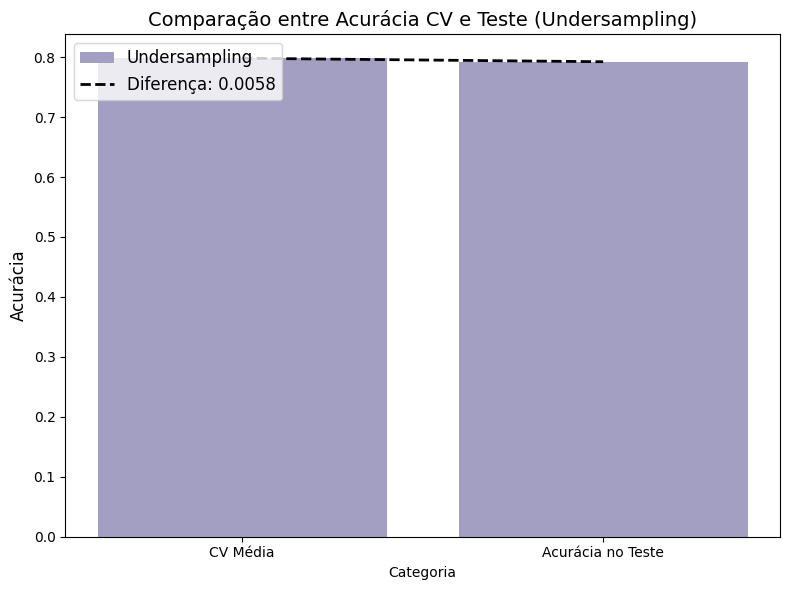

In [100]:
# Verificação de Overfitting
limiar = 0.05
diff_undersampled = abs(cv_mean - acc_test)

if diff_undersampled > limiar:
    print("\nAtenção: Diferença significativa entre CV (treino undersampled) e teste.")
    print(f"→ CV Média: {cv_mean:.4f}")
    print(f"→ Teste   : {acc_test:.4f}")
    print(f"→ Diferença: {diff_undersampled:.4f}")
    print("Possível overfitting ou distribuição diferente entre treino/teste.")
else:
    print("\nModelo generaliza bem com base na comparação CV treino undersampled vs Teste.")

data_undersampled = pd.DataFrame({
    "Categoria": ["CV Média", "Acurácia no Teste"],
    "Acurácia": [cv_mean, acc_test],
    "Modelo": ["Undersampling"] * 2
})
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x="Categoria", y="Acurácia", data=data_undersampled, ax=ax, palette='Purples', hue="Modelo")
ax.plot([0, 1], [cv_mean, acc_test], 'k--', lw=2, label=f'Diferença: {diff_undersampled:.4f}')
ax.legend(loc='upper left', fontsize=12)
ax.set_title('Comparação entre Acurácia CV e Teste (Undersampling)', fontsize=14)
ax.set_ylabel('Acurácia', fontsize=12)
plt.tight_layout()
plt.show()

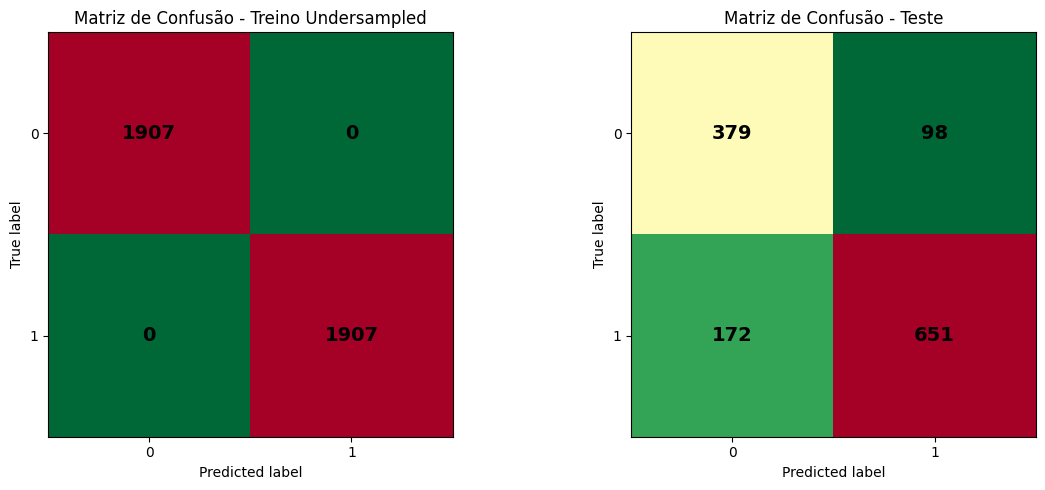

In [74]:
# Matrizes de Confusão
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_estimator(
    best_knn, X_train_bal_scaled, y_train_bal,
    ax=axes[0],
    cmap='RdYlGn_r',
    colorbar=False
)
axes[0].set_title("Matriz de Confusão - Treino Undersampled")

ConfusionMatrixDisplay.from_estimator(
    best_knn, X_test_scaled, y_test,
    ax=axes[1],
    cmap='RdYlGn_r',
    colorbar=False
)
axes[1].set_title("Matriz de Confusão - Teste")

def style_confusion_texts(ax, color='black', weight='bold', fontsize=14):
    for text in ax.texts:
        text.set_color(color)
        text.set_fontweight(weight)
        text.set_fontsize(fontsize)

style_confusion_texts(axes[0])
style_confusion_texts(axes[1])

plt.tight_layout()
plt.show()

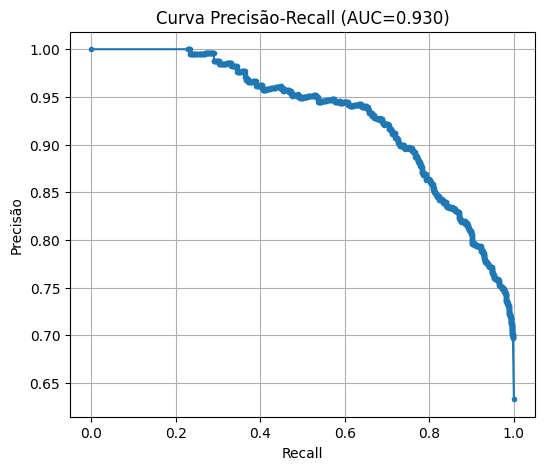

In [75]:
# Curva de Precisão-Recall
precisao, recall, _ = precision_recall_curve(y_test, best_knn.predict_proba(X_test_scaled)[:,1])
pr_auc = auc(recall, precisao)

plt.figure(figsize=(6,5))
plt.plot(recall, precisao, marker='.')
plt.title(f'Curva Precisão-Recall (AUC={pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.grid(True)
plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

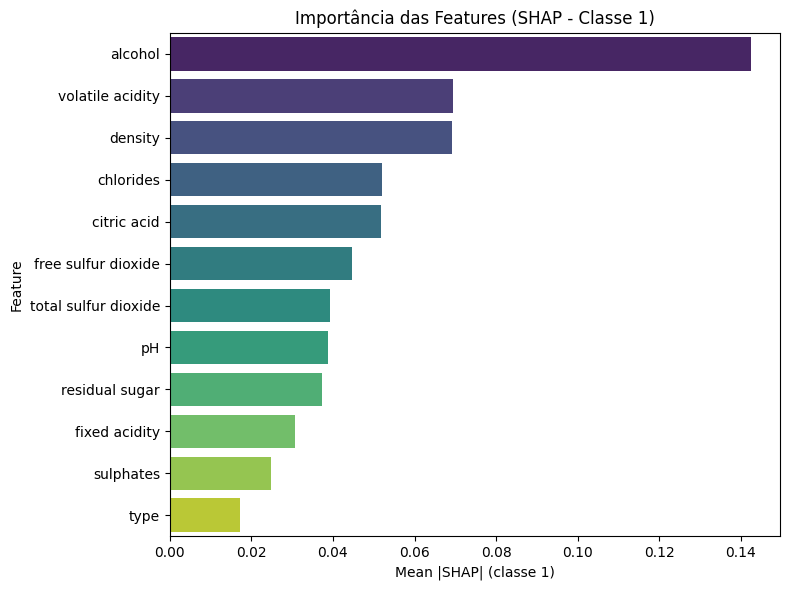


Importância média das características para prever vinhos bons:
                 Feature  Mean |SHAP| (classe 1)
11               alcohol                0.142437
2       volatile acidity                0.069429
8                density                0.069233
5              chlorides                0.052026
3            citric acid                0.051814
6    free sulfur dioxide                0.044707
7   total sulfur dioxide                0.039170
9                     pH                0.038916
4         residual sugar                0.037258
1          fixed acidity                0.030780
10             sulphates                0.024895
0                   type                0.017331


In [ ]:
# SHAP - Explicabilidade
# (classe 1 = vinho bom)

feature_names = X.columns.tolist()
X_shap_train = pd.DataFrame(X_train_bal_scaled[:100], columns=feature_names)
X_shap_test = pd.DataFrame(X_test_scaled[:50], columns=feature_names)

def predict_proba_class(X_array):
    return best_knn.predict_proba(X_array)

explainer = shap.KernelExplainer(predict_proba_class, X_shap_train)

shap_values = explainer.shap_values(X_shap_test)

if isinstance(shap_values, list):
    if len(shap_values) == 2:
        shap_values_class1 = shap_values[1]
    else:
        raise ValueError("Esperava-se shap_values como lista com 2 elementos para problema binário.")
elif isinstance(shap_values, np.ndarray):
    shap_values_class1 = shap_values
else:
    raise ValueError("Estrutura inesperada para shap_values.")

mean_abs_shap_1 = np.abs(shap_values_class1[:, :, 1]).mean(axis=0)

if mean_abs_shap_1.shape[0] != len(feature_names):
    raise ValueError(f"Mismatch entre número de features e tamanho do vetor de importância! ({mean_abs_shap_1.shape[0]} vs {len(feature_names)})")

mean_abs_shap_1 = mean_abs_shap_1.flatten()

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Mean |SHAP| (classe 1)': mean_abs_shap_1
}).sort_values(by='Mean |SHAP| (classe 1)', ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x='Mean |SHAP| (classe 1 = Vinho Bom)', y='Feature', data=feature_importance, hue='Feature', legend=False, palette='viridis')
plt.title('Importância das Features (SHAP - Classe 1 = Vinho Bom) Undersampling')
plt.tight_layout()
plt.show()

print("\nImportância média das características para prever vinhos bons:")
print(feature_importance)

Seção 2: KNN + Oversampling

In [76]:
# Balanceamento com Oversampling
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train_oversampled, y_train_oversampled = ros.fit_resample(X_train, y_train)
print(f'\nAntes do oversampling, treino tem {np.bincount(y_train)}')
print(f'Depois do oversampling, treino tem {np.bincount(y_train_oversampled)}')


Antes do oversampling, treino tem [1907 3290]
Depois do oversampling, treino tem [3290 3290]


In [77]:
# Normalização dos dados (fit no treino balanceado, aplicando em treino e teste)
scaler = StandardScaler()
X_train_oversampled_scaled = scaler.fit_transform(X_train_oversampled)
X_test_scaled = scaler.transform(X_test)

In [78]:
# Ajuste de Hiperparâmetros com Cross-validation
grid.fit(X_train_oversampled_scaled, y_train_oversampled)
print("\nMelhores parâmetros encontrados (com oversampling):", grid.best_params_)
best_knn_oversampled = grid.best_estimator_


Melhores parâmetros encontrados (com oversampling): {'n_neighbors': 45, 'p': 1, 'weights': 'distance'}


In [79]:
# Avaliação de métricas
tabela_metricas_oversampled = gerar_tabela_metricas(
    best_knn_oversampled, X_train_oversampled_scaled, y_train_oversampled, X_test_scaled, y_test
)
print("\n===== Tabela de Métricas (com RandomOverSampler) =====")
print(tabela_metricas_oversampled)
acc_train_oversampled = accuracy_score(y_train_oversampled, best_knn_oversampled.predict(X_train_oversampled_scaled))
acc_test_oversampled = accuracy_score(y_test, best_knn_oversampled.predict(X_test_scaled))
print(f"\nAcurácia Treino (Oversampling): {acc_train_oversampled:.4f}")
print(f"Acurácia Teste (Oversampling) : {acc_test_oversampled:.4f}")


===== Tabela de Métricas (com RandomOverSampler) =====
                Vinhos Ruins Vinhos Bons     Média Média Ponderada
Teste  Precisão     0.718095    0.870968  0.794531        0.814875
       Recall       0.790356     0.82017  0.805263        0.809231
       F1-Score     0.752495    0.844806  0.798651        0.810935
       Suporte         477.0       823.0       NaN             NaN
Treino Precisão          1.0         1.0       1.0             1.0
       Recall            1.0         1.0       1.0             1.0
       F1-Score          1.0         1.0       1.0             1.0
       Suporte        3290.0      3290.0       NaN             NaN

Acurácia Treino (Oversampling): 1.0000
Acurácia Teste (Oversampling) : 0.8092


In [87]:
# Cross-validation para KNN com Oversampling
cv_scores_oversampled = cross_val_score(best_knn_oversampled, X_train_oversampled_scaled, y_train_oversampled, cv=5, scoring='accuracy')
cv_mean_oversampled = cv_scores_oversampled.mean()
cv_std_oversampled = cv_scores_oversampled.std()

print(f"\nCross-Validation Accuracy (Treino oversampled): {cv_mean_oversampled:.4f} ± {cv_std_oversampled:.4f}")


Cross-Validation Accuracy (Treino oversampled): 0.8818 ± 0.0188



Atenção: Diferença significativa entre CV (treino oversampled) e teste.
→ CV Média: 0.8818
→ Teste   : 0.7923
→ Diferença: 0.0895
Possível overfitting ou distribuição diferente entre treino/teste.


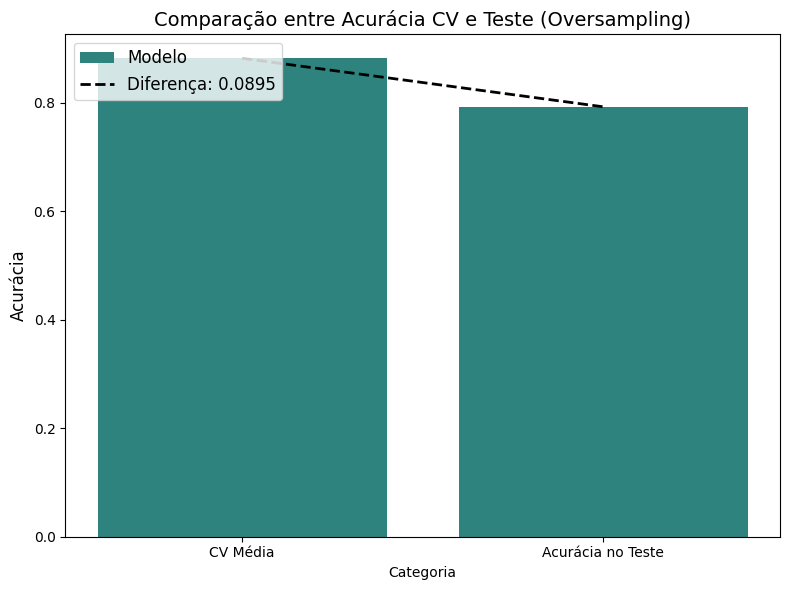

In [98]:
# Verificação de Overfitting para KNN com Oversampling
diff = abs(cv_mean_oversampled - acc_test)
limiar = 0.05

if diff > limiar:
    print("\nAtenção: Diferença significativa entre CV (treino oversampled) e teste.")
    print(f"→ CV Média: {cv_mean_oversampled:.4f}")
    print(f"→ Teste   : {acc_test:.4f}")
    print(f"→ Diferença: {diff:.4f}")
    print("Possível overfitting ou distribuição diferente entre treino/teste.")
else:
    print("\nModelo generaliza bem com base na comparação CV treino oversampled vs Teste.")

data = pd.DataFrame({
    "Categoria": ["CV Média", "Acurácia no Teste"],
    "Acurácia": [cv_mean_oversampled, acc_test],
    "Modelo": ["Modelo"] * 2
})
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x="Categoria", y="Acurácia", data=data, ax=ax, palette='viridis', hue="Modelo")
ax.plot([0, 1], [cv_mean_oversampled, acc_test], 'k--', lw=2, label=f'Diferença: {diff:.4f}')  # Linha pontilhada com legenda
ax.legend(loc='upper left', fontsize=12)
ax.set_title('Comparação entre Acurácia CV e Teste (Oversampling)', fontsize=14)
ax.set_ylabel('Acurácia', fontsize=12)
plt.tight_layout()
plt.show()

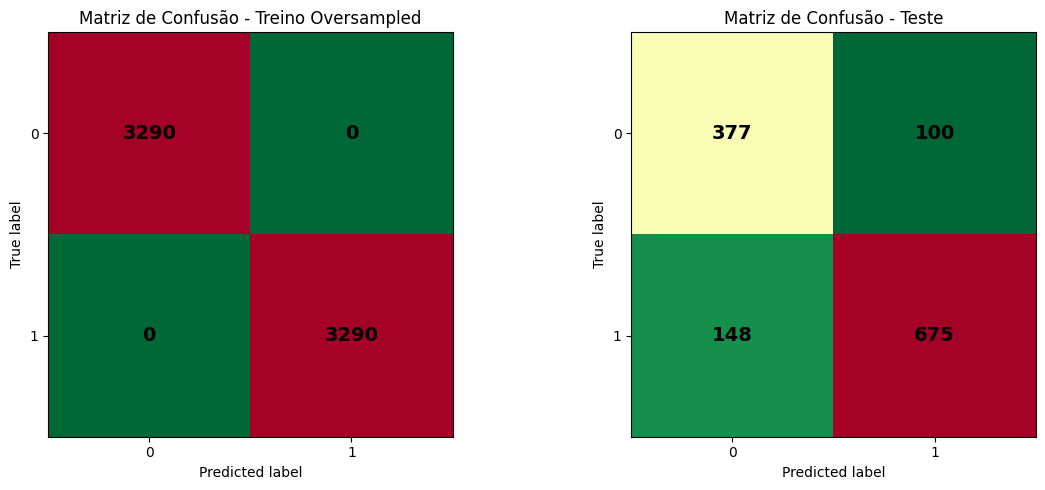

In [80]:
# Matrizes de Confusão
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_estimator(
    best_knn_oversampled, X_train_oversampled_scaled, y_train_oversampled,
    ax=axes[0],
    cmap='RdYlGn_r',
    colorbar=False
)
axes[0].set_title("Matriz de Confusão - Treino Oversampled")

ConfusionMatrixDisplay.from_estimator(
    best_knn_oversampled, X_test_scaled, y_test,
    ax=axes[1],
    cmap='RdYlGn_r',
    colorbar=False
)
axes[1].set_title("Matriz de Confusão - Teste")

def style_confusion_texts(ax, color='black', weight='bold', fontsize=14):
    for text in ax.texts:
        text.set_color(color)
        text.set_fontweight(weight)
        text.set_fontsize(fontsize)

style_confusion_texts(axes[0])
style_confusion_texts(axes[1])

plt.tight_layout()
plt.show()

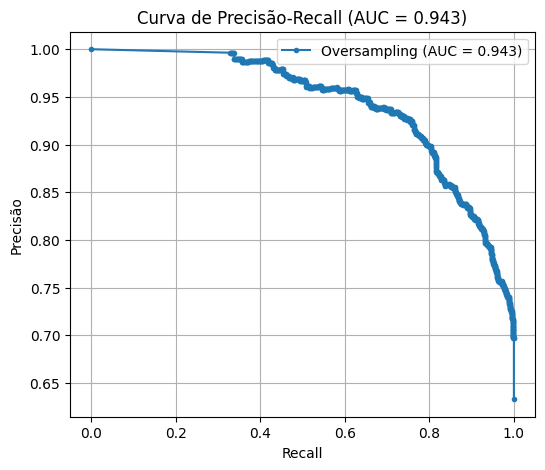

In [81]:
# Curva de Precisão-Recall
precisao, recall, _ = precision_recall_curve(y_test, best_knn_oversampled.predict_proba(X_test_scaled)[:, 1])
pr_auc = auc(recall, precisao)
plt.figure(figsize=(6, 5))
plt.plot(recall, precisao, marker='.', label=f'Oversampling (AUC = {pr_auc:.3f})')
plt.title(f'Curva de Precisão-Recall (AUC = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.grid(True)
plt.legend()
plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

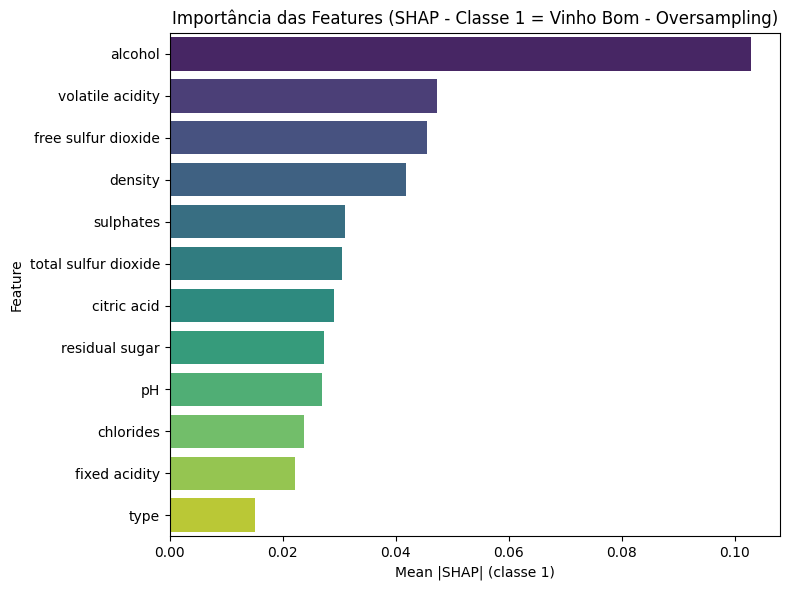


Importância média das características para prever vinhos bons (oversampling):
                 Feature  Mean |SHAP| (classe 1)
11               alcohol                0.102897
2       volatile acidity                0.047309
6    free sulfur dioxide                0.045594
8                density                0.041869
10             sulphates                0.031098
7   total sulfur dioxide                0.030452
3            citric acid                0.029155
4         residual sugar                0.027236
9                     pH                0.026999
5              chlorides                0.023798
1          fixed acidity                0.022157
0                   type                0.015149


In [86]:
# SHAP - Explicabilidade para Oversampling
feature_names = X_train.columns.tolist()
X_shap_train_oversampled = pd.DataFrame(X_train_oversampled_scaled[:100], columns=feature_names)
X_shap_test_oversampled = pd.DataFrame(X_test_scaled[:50], columns=feature_names)

explainer_oversampled = shap.KernelExplainer(best_knn_oversampled.predict_proba, X_shap_train_oversampled)
shap_values_oversampled = explainer_oversampled.shap_values(X_shap_test_oversampled)

if isinstance(shap_values_oversampled, list):
    if len(shap_values_oversampled) == 2:
        shap_values_class1 = shap_values_oversampled[1]  # Classe 1 (Vinho Bom)
    else:
        raise ValueError("Esperava-se shap_values como lista com 2 elementos para problema binário.")
elif isinstance(shap_values_oversampled, np.ndarray):
    shap_values_class1 = shap_values_oversampled
else:
    raise ValueError("Estrutura inesperada para shap_values.")

shap_values_class1 = shap_values_class1[:, :, 1]

mean_abs_shap_1_oversampled = np.abs(shap_values_class1).mean(axis=0)

if mean_abs_shap_1_oversampled.shape[0] != len(feature_names):
    raise ValueError(f"Mismatch entre número de features e tamanho do vetor de importância! ({mean_abs_shap_1_oversampled.shape[0]} vs {len(feature_names)})")

mean_abs_shap_1_oversampled = mean_abs_shap_1_oversampled.flatten()

feature_importance_oversampled = pd.DataFrame({
    'Feature': feature_names,
    'Mean |SHAP| (classe 1)': mean_abs_shap_1_oversampled
}).sort_values(by='Mean |SHAP| (classe 1)', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x='Mean |SHAP| (classe 1)', y='Feature', data=feature_importance_oversampled, palette='viridis', hue='Feature', legend=False)
plt.title('Importância das Features (SHAP - Classe 1 = Vinho Bom - Oversampling)')
plt.tight_layout()
plt.show()

print("\nImportância média das características para prever vinhos bons (oversampling):")
print(feature_importance_oversampled)

Comparação KNN - Undersampling X Oversampling

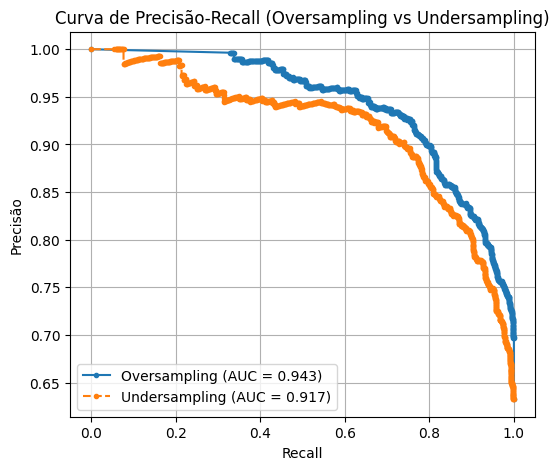

In [82]:
# Comparação: Curva de Precisão-Recall Undersampling X Oversampling
precisao_os, recall_os, _ = precision_recall_curve(y_test, best_knn_oversampled.predict_proba(X_test_scaled)[:, 1])
pr_auc_os = auc(recall_os, precisao_os)

precisao_us, recall_us, _ = precision_recall_curve(y_test, best_knn.predict_proba(X_test_scaled)[:, 1])
pr_auc_us = auc(recall_us, precisao_us)

plt.figure(figsize=(6, 5))

plt.plot(recall_os, precisao_os, marker='.', label=f'Oversampling (AUC = {pr_auc_os:.3f})')

plt.plot(recall_us, precisao_us, marker='.', label=f'Undersampling (AUC = {pr_auc_us:.3f})', linestyle='--')

plt.title('Curva de Precisão-Recall (Oversampling vs Undersampling)')
plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.legend()
plt.grid(True)
plt.show()

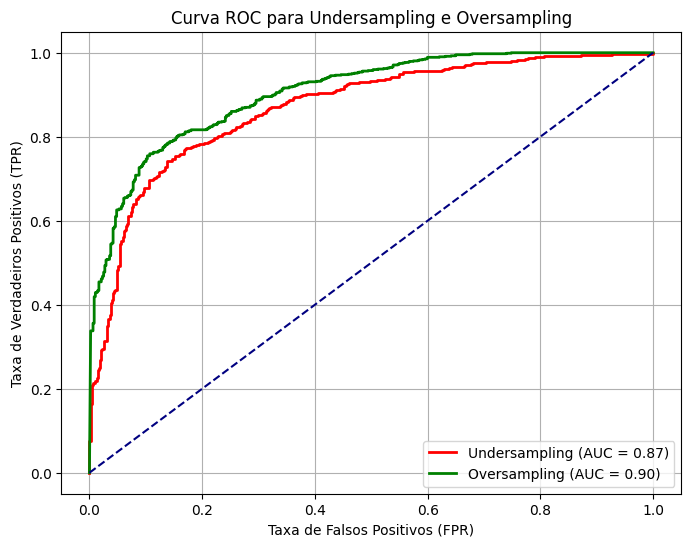

In [83]:
# Predições de probabilidade para a classe positiva
fpr_us, tpr_us, _ = roc_curve(y_test, best_knn.predict_proba(X_test_scaled)[:, 1])
fpr_os, tpr_os, _ = roc_curve(y_test, best_knn_oversampled.predict_proba(X_test_scaled)[:, 1])

# Cálculo da AUC
roc_auc_us = auc(fpr_us, tpr_us)
roc_auc_os = auc(fpr_os, tpr_os)

plt.figure(figsize=(8, 6))

# Plotando a curva ROC
plt.plot(fpr_us, tpr_us, color='red', lw=2, label=f'Undersampling (AUC = {roc_auc_us:.2f})')
plt.plot(fpr_os, tpr_os, color='green', lw=2, label=f'Oversampling (AUC = {roc_auc_os:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Linha de chance aleatória

plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC para Undersampling e Oversampling')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

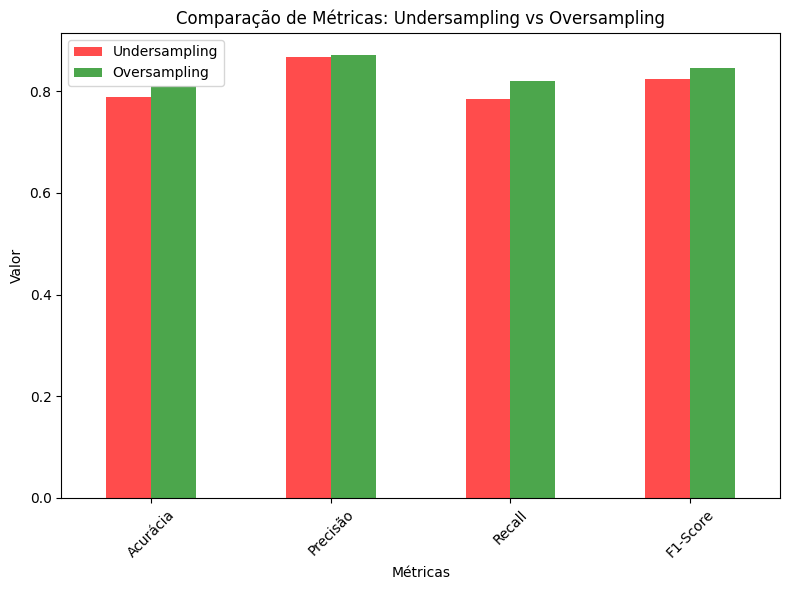

In [84]:
# Comparação de Métricas
acc_us = accuracy_score(y_test, best_knn.predict(X_test_scaled))
precision_us = precision_score(y_test, best_knn.predict(X_test_scaled))
recall_us = recall_score(y_test, best_knn.predict(X_test_scaled))
f1_us = f1_score(y_test, best_knn.predict(X_test_scaled))

acc_os = accuracy_score(y_test, best_knn_oversampled.predict(X_test_scaled))
precision_os = precision_score(y_test, best_knn_oversampled.predict(X_test_scaled))
recall_os = recall_score(y_test, best_knn_oversampled.predict(X_test_scaled))
f1_os = f1_score(y_test, best_knn_oversampled.predict(X_test_scaled))

metrics = ['Acurácia', 'Precisão', 'Recall', 'F1-Score']
undersampling_values = [acc_us, precision_us, recall_us, f1_us]
oversampling_values = [acc_os, precision_os, recall_os, f1_os]
df_metrics = pd.DataFrame({
    'Métricas': metrics,
    'Undersampling': undersampling_values,
    'Oversampling': oversampling_values
})
df_metrics.set_index('Métricas').plot(kind='bar', figsize=(8, 6), color=['red', 'green'], alpha=0.7)
plt.title('Comparação de Métricas: Undersampling vs Oversampling')
plt.ylabel('Valor')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

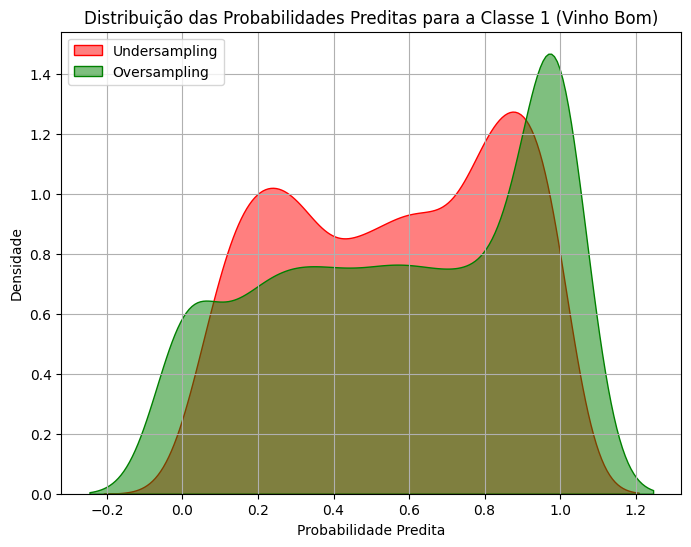

In [85]:
# Distribuição das Probabilidades Preditas para a classe 1 (bom)
plt.figure(figsize=(8, 6))

prob_us = best_knn.predict_proba(X_test_scaled)[:, 1]
prob_os = best_knn_oversampled.predict_proba(X_test_scaled)[:, 1]

sns.kdeplot(prob_us, color='red', label='Undersampling', fill=True, alpha=0.5)
sns.kdeplot(prob_os, color='green', label='Oversampling', fill=True, alpha=0.5)

plt.title('Distribuição das Probabilidades Preditas para a Classe 1 (Vinho Bom)')
plt.xlabel('Probabilidade Predita')
plt.ylabel('Densidade')
plt.legend()
plt.grid(True)
plt.show()